In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

import networkx as nx

from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs

%matplotlib inline

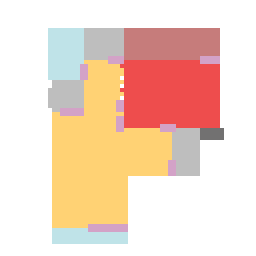

<PlanMasks 134731715394912>

In [4]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [5]:
_room_to_find = NodeType.LIVING_ROOM
room = [pm.masks[i] for i, n in enumerate(pm.graph.nodes) if n == _room_to_find ][0]

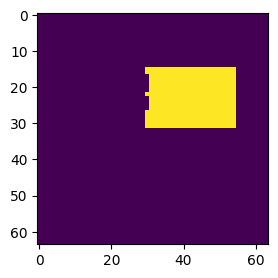

In [11]:
plt.figure(figsize=(3,3))
plt.imshow(room)

In [47]:
from minimal.correction import RoomAreas

ra = RoomAreas(_room_to_find, room)

In [49]:
plt.figure(figsize=(3,3))
plt.imshow(ra.to_mask())

tensor(True)

<Figure size 300x300 with 0 Axes>